In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [19]:
MARKET_TICKER = "KXRATECUTCOUNT-25DEC31-T3"
CSV_PATH = Path(f"/content/{MARKET_TICKER}_history.csv")

print("Looking for data at:", CSV_PATH)
print("File exists:", CSV_PATH.exists())


Looking for data at: /content/KXRATECUTCOUNT-25DEC31-T3_history.csv
File exists: True


In [20]:
def load_belief_history(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(
            f"Required data file not found: {csv_path}\n"
            "Upload the CSV into the Colab runtime."
        )

    df = pd.read_csv(csv_path, parse_dates=["time"])
    df = df.sort_values("time").reset_index(drop=True)

    expected_cols = {"time", "price", "volume", "open_interest"}
    missing = expected_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    return df


df = load_belief_history(CSV_PATH)
df.head()


,time,price,volume,open_interest
0,2025-12-01 01:00:00,0.85,31,1046320
1,2025-12-01 02:00:00,0.86,1228,1046467
2,2025-12-01 03:00:00,0.86,1904,1048371
3,2025-12-01 04:00:00,NaN,0,1048371
4,2025-12-01 05:00:00,0.89,8277,1056568


In [21]:
print(f"Rows: {len(df)}")
print(f"Time span: {df['time'].min()} → {df['time'].max()}")

df.describe()


Rows: 633
Time span: 2025-12-01 01:00:00 → 2025-12-31 00:00:00


,time,price,volume,open_interest
count,633,456.000000,633.000000,6.330000e+02
mean,2025-12-15 04:31:05.402843648,0.960088,1331.843602,1.098343e+06
min,2025-12-01 01:00:00,0.840000,0.000000,1.046320e+06
25%,2025-12-07 17:00:00,0.930000,0.000000,1.084834e+06
50%,2025-12-14 14:00:00,0.990000,54.000000,1.095652e+06
75%,2025-12-22 12:00:00,0.990000,584.000000,1.110716e+06
max,2025-12-31 00:00:00,0.990000,50500.000000,1.144628e+06
std,NaN,0.038259,4751.670883,1.817994e+04


In [22]:
def belief_volatility(series: pd.Series) -> float:
    return np.mean(np.abs(series.diff().dropna()))

def belief_entropy(series: pd.Series) -> float:
    p = series.clip(1e-6, 1 - 1e-6)
    return -np.mean(p * np.log(p) + (1 - p) * np.log(1 - p))


volatility = belief_volatility(df["price"])
entropy = belief_entropy(df["price"])

print(f"Average belief volatility: {volatility:.4f}")
print(f"Average belief entropy: {entropy:.4f}")


Average belief volatility: 0.0045
Average belief entropy: 0.1499


In [23]:
COLLAPSE_THRESHOLD = 0.95

collapse_points = df[df["price"] >= COLLAPSE_THRESHOLD]

if not collapse_points.empty:
    collapse_time = collapse_points.iloc[0]["time"]
    print("Belief collapse detected at:", collapse_time)
else:
    print("No belief collapse detected in this window.")


Belief collapse detected at: 2025-12-09 09:00:00


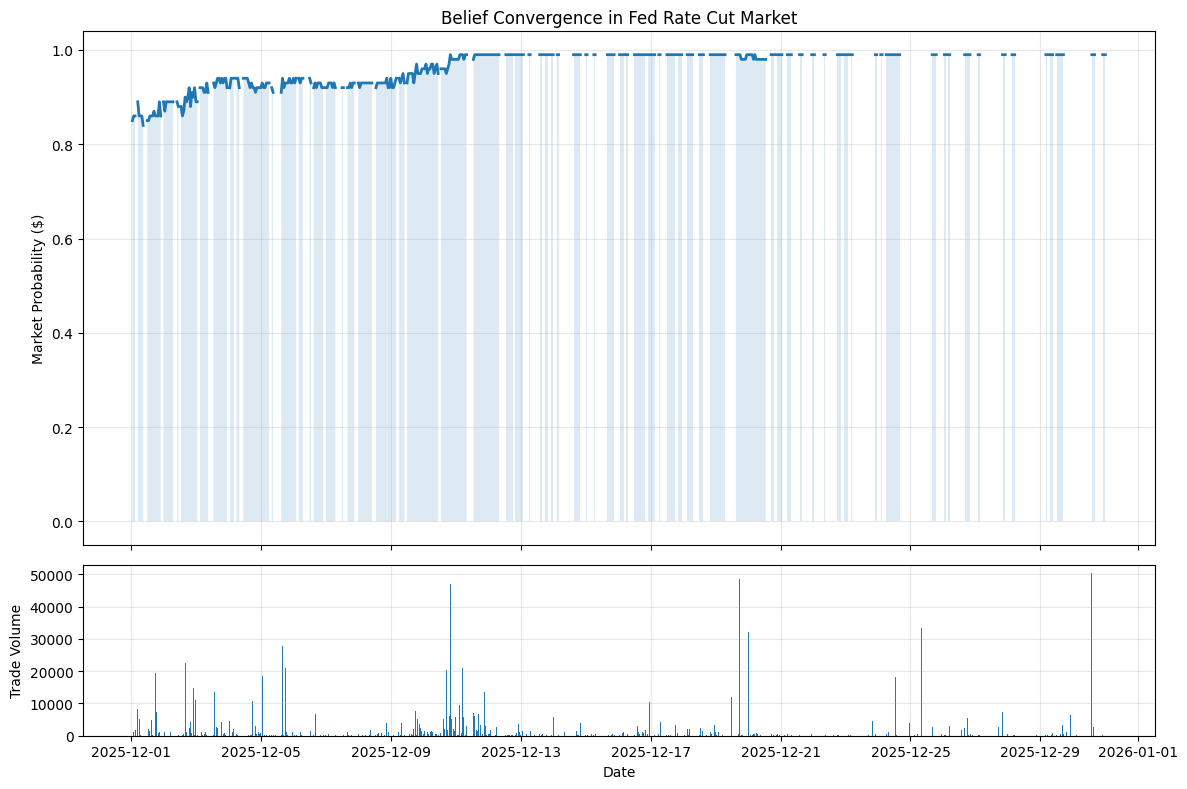

In [24]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# Belief trajectory
ax1.plot(df["time"], df["price"], linewidth=2)
ax1.fill_between(df["time"], df["price"], alpha=0.15)
ax1.set_ylabel("Market Probability ($)")
ax1.set_title("Belief Convergence in Fed Rate Cut Market")
ax1.grid(alpha=0.3)

# Trading activity
ax2.bar(df["time"], df["volume"], width=0.03)
ax2.set_ylabel("Trade Volume")
ax2.set_xlabel("Date")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretation

We observe:
- Gradual belief drift during periods of ambiguous information
- Abrupt belief collapse following decisive signals
- Reduced trading activity after convergence

These patterns are consistent with belief aggregation models featuring
stochastic updating and absorbing states.
